In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 15)
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
%matplotlib inline

In [2]:
import talib
from ta import add_all_ta_features

### Read full database

In [5]:
DATA_PATH = r'../data/'
FILE_NAME = '20220313_034756_111.pkl'
FULL_PATH = Path(DATA_PATH,FILE_NAME)

In [35]:
%time
raw = pd.read_pickle(FULL_PATH)
raw.shape

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


(5675397, 14)

In [37]:
raw.dtypes

symbol                              object
openTimets                           int64
closeTimets                          int64
openTime                    datetime64[ns]
closeTime                   datetime64[ns]
open                                object
high                                object
low                                 object
close                               object
volume                              object
numTrades                            int64
quoteAssetVolume                    object
takerBuyBaseAssetVolume             object
takerBuyQuoteAssetVolume            object
dtype: object

In [38]:
raw.symbol.value_counts()

BTCUSDT     87964
ETHUSDT     80325
BCHUSDT     78208
XRPUSDT     76486
EOSUSDT     76292
            ...  
BAKEUSDT    28582
BTTUSDT     28339
GTCUSDT     26390
TLMUSDT     23032
KEEPUSDT    22843
Name: symbol, Length: 111, dtype: int64

### Prepare and subset dataset

In [265]:
df = raw.query('symbol=="ETHUSDT"')
assert df.isnull().sum().sum() == 0
df.shape

(80325, 14)

In [266]:
# create datatypes dictionary
datatypes = {k:'float32' if k!='numTrades' else 'int32' for k in df.loc[:,'open':].columns}
# assign datatypes
df = df.astype(datatypes)
assert df.isnull().sum().sum() == 0
df.dtypes

symbol                              object
openTimets                           int64
closeTimets                          int64
openTime                    datetime64[ns]
closeTime                   datetime64[ns]
open                               float32
high                               float32
low                                float32
close                              float32
volume                             float32
numTrades                            int32
quoteAssetVolume                   float32
takerBuyBaseAssetVolume            float32
takerBuyQuoteAssetVolume           float32
dtype: object

In [268]:
df.to_pickle('../data/eth.pkl')

### Read dataset from disk

In [3]:
raw = pd.read_pickle('../data/eth.pkl')

### Group on desired frequency

In [4]:
df = \
    raw.groupby(pd.Grouper(key="openTime", freq="1H"))\
    .agg(
        cnt=pd.NamedAgg(column="symbol", aggfunc="size"),
        opentime=pd.NamedAgg(column="openTime", aggfunc="min"),
        closetime=pd.NamedAgg(column="openTime", aggfunc="min"),
        open=pd.NamedAgg(column="open", aggfunc="first"),
        high=pd.NamedAgg(column="high", aggfunc="max"),
        low=pd.NamedAgg(column="low", aggfunc="min"),
        close=pd.NamedAgg(column="close", aggfunc="last"),
        volume=pd.NamedAgg(column="volume", aggfunc="sum"),
        numtrade=pd.NamedAgg(column="numTrades", aggfunc="sum"),
    )\
    .query('cnt >= 4')\
    .drop('cnt',axis=1)\
    .assign(closetime = lambda x : x.closetime + pd.Timedelta(minutes=59))\
    .reset_index(drop=True)

# alternative way to resample and regroup data
# df = raw.resample('30min',on='opentime').agg({'close':'last','high':'max'}).tail(10)
df.tail()

,opentime,closetime,open,high,low,close,volume,numtrade
20076,2022-03-12 20:00:00,2022-03-12 20:59:00,2576.760010,2591.659912,2573.870117,2586.800049,25150.187500,35923
20077,2022-03-12 21:00:00,2022-03-12 21:59:00,2586.800049,2591.719971,2583.060059,2585.649902,13017.638672,24267
20078,2022-03-12 22:00:00,2022-03-12 22:59:00,2585.649902,2591.379883,2583.260010,2585.830078,10603.583008,26367
20079,2022-03-12 23:00:00,2022-03-12 23:59:00,2585.840088,2590.199951,2560.000000,2567.639893,35792.011719,49081
20080,2022-03-13 00:00:00,2022-03-13 00:59:00,2567.629883,2573.780029,2555.810059,2565.979980,41614.472656,50466


### Inspect Time Series

count                  20081
mean     2021-01-18 16:00:00
min      2019-11-27 08:00:00
25%      2020-06-23 12:00:00
50%      2021-01-18 16:00:00
75%      2021-08-15 20:00:00
max      2022-03-13 00:00:00
Name: opentime, dtype: object
AxesSubplot(0.125,0.125;0.775x0.755)


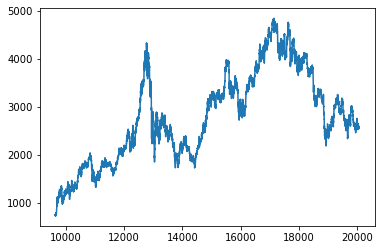

In [5]:
print(df.opentime.describe(datetime_is_numeric=True))
# print(df.close.plot())
print(df.query('opentime >= 2021').close.plot())

In [6]:
df = df.query('opentime >= 2021').copy()
df.shape

(10465, 8)

### Decompose Time Series

In [7]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
# from statsmodels.tsa.seasonal import seasonal_decompose
# # from statsmodels.tsa.seasonal import MSTL
# print(plot_acf(df.close))
# print(plot_pacf(df.close))
# # stl_kwargs = {"seasonal_deg": 0} 
# # model = MSTL(df.close, periods=(24, 24 * 7), stl_kwargs=stl_kwargs)
# # res = model.fit()
# # res.plot()

### Create Features to Avoid Leakage
> __close -> fx_close = close.shift(1)__

In [8]:
options_antileakage_feats = ['open','high','low','close','volume']
for ff in options_antileakage_feats:
    df[f'fx_{ff}'] = df[ff].shift(1)

In [9]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume'],
      dtype='object')

### Create Lag Features

In [10]:
options_lags_feats = ['close','volume']
options_lags = [1,2,3,24,48]
for ff in options_lags_feats:
    for ll in options_lags:
        df[f'fx_{ff}_lag_{str(ll).zfill(3)}'] = df[ff].shift(ll)

In [11]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume',
       'fx_close_lag_001', 'fx_close_lag_002', 'fx_close_lag_003',
       'fx_close_lag_024', 'fx_close_lag_048', 'fx_volume_lag_001',
       'fx_volume_lag_002', 'fx_volume_lag_003', 'fx_volume_lag_024',
       'fx_volume_lag_048'],
      dtype='object')

In [12]:
df.shape

(10465, 23)

### Create Diff Features

In [13]:
options_diffs_feats = ['fx_close','fx_volume']
options_diffs = [1,2,3,24,48]
for ff in options_diffs_feats:
    for ll in options_diffs:
        df[f'{ff}_diff_{str(ll).zfill(3)}'] = df[ff].diff(ll)

In [14]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume',
       'fx_close_lag_001', 'fx_close_lag_002', 'fx_close_lag_003',
       'fx_close_lag_024', 'fx_close_lag_048', 'fx_volume_lag_001',
       'fx_volume_lag_002', 'fx_volume_lag_003', 'fx_volume_lag_024',
       'fx_volume_lag_048', 'fx_close_diff_001', 'fx_close_diff_002',
       'fx_close_diff_003', 'fx_close_diff_024', 'fx_close_diff_048',
       'fx_volume_diff_001', 'fx_volume_diff_002', 'fx_volume_diff_003',
       'fx_volume_diff_024', 'fx_volume_diff_048'],
      dtype='object')

In [15]:
df.shape

(10465, 33)

### Create Rolling Features

In [16]:
options_wndf_feats = ['fx_close','fx_volume']
options_wndf = [24,24*7]
for ff in options_wndf_feats:
    for ll in options_wndf:
        df[f'{ff}_min_{str(ll).zfill(3)}'] = df[ff].rolling(ll).min()
        df[f'{ff}_max_{str(ll).zfill(3)}'] = df[ff].rolling(ll).max()
        df[f'{ff}_std_{str(ll).zfill(3)}'] = df[ff].rolling(ll).std()

In [17]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high', 'fx_low', 'fx_close', 'fx_volume',
       'fx_close_lag_001', 'fx_close_lag_002', 'fx_close_lag_003',
       'fx_close_lag_024', 'fx_close_lag_048', 'fx_volume_lag_001',
       'fx_volume_lag_002', 'fx_volume_lag_003', 'fx_volume_lag_024',
       'fx_volume_lag_048', 'fx_close_diff_001', 'fx_close_diff_002',
       'fx_close_diff_003', 'fx_close_diff_024', 'fx_close_diff_048',
       'fx_volume_diff_001', 'fx_volume_diff_002', 'fx_volume_diff_003',
       'fx_volume_diff_024', 'fx_volume_diff_048', 'fx_close_min_024',
       'fx_close_max_024', 'fx_close_std_024', 'fx_close_min_168',
       'fx_close_max_168', 'fx_close_std_168', 'fx_volume_min_024',
       'fx_volume_max_024', 'fx_volume_std_024', 'fx_volume_min_168',
       'fx_volume_max_168', 'fx_volume_std_168'],
      dtype='object')

In [18]:
df.shape

(10465, 45)

### Create TA Features - Manually

In [19]:
# df = \
#     df.assign(
#         fx_sma_fast = lambda x : talib.SMA(x.close.shift(1),8),
#         fx_sma_slow = lambda x : x.close.shift(1).rolling(24).mean(),
#         fx_ema_fast = lambda x : talib.EMA(x.close.shift(1),8),
#         fx_ema_slow = lambda x : talib.EMA(x.close.shift(1),24),
#         fx_atr = lambda x : talib.ATR(x.high.shift(1),x.low.shift(1),x.close.shift(1),12),
#         fx_adx = lambda x : talib.ADX(x.high.shift(1),x.low.shift(1),x.close.shift(1),20),
#         fx_rsi = lambda x : talib.RSI(x.close.shift(1),12),
#         fx_bb_upper = lambda x : talib.BBANDS(x.close.shift(1))[0],
#         fx_bb_middle = lambda x : talib.BBANDS(x.close.shift(1))[1],
#         fx_bb_lower = lambda x : talib.BBANDS(x.close.shift(1))[2],
#     ).assign(
#         fx_sma_fast_slow_frc = lambda x : (x.fx_sma_fast/x.fx_sma_slow)
#     )
#
# df.tail(2)
# df.columns
# df.shape

### Create TA Features - Automatically

In [20]:
df = add_all_ta_features(
    df, 
    open='fx_open', 
    high='fx_high', 
    low='fx_low', 
    close='fx_close', 
    volume='fx_volume', 
    fillna=True)
df.columns

/Users/takis/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/takis/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high',
       ...
       'momentum_wr', 'momentum_ao', 'momentum_kama', 'momentum_roc',
       'momentum_ppo', 'momentum_ppo_signal', 'momentum_ppo_hist', 'others_dr',
       'others_dlr', 'others_cr'],
      dtype='object', length=128)

In [21]:
df = \
    df.assign(
        sma_fast_slow_frc = lambda x : (x.trend_sma_fast/x.trend_sma_slow),
        ema_fast_slow_frc = lambda x : (x.trend_ema_fast/x.trend_ema_slow)
    )

### Enable Pattern Recognition Features

In [22]:
talib.get_function_groups().keys()
# pattern_recognition_functions = [x for x in dir(talib) if x.startswith('CDL')]
pattern_recognition_functions = talib.get_function_groups().get('Pattern Recognition')
# pattern_recognition_functions[1::10]
# create pattern recognition features
pattern_features = {
    f'pt_{x.lower()}': getattr(talib,x)(df['fx_open'],df['fx_high'],df['fx_low'],df['fx_close'])
                    for x in pattern_recognition_functions
    }

In [23]:
df = df.assign(**pattern_features)
df.head(2)

,opentime,closetime,open,high,low,close,volume,...,pt_cdltakuri,pt_cdltasukigap,pt_cdlthrusting,pt_cdltristar,pt_cdlunique3river,pt_cdlupsidegap2crows,pt_cdlxsidegap3methods
9616,2021-01-01 00:00:00,2021-01-01 00:59:00,737.179993,740.000000,730.0,734.599976,98092.523438,...,0,0,0,0,0,0,0
9617,2021-01-01 01:00:00,2021-01-01 01:59:00,734.609985,750.400024,734.0,749.330017,164084.062500,...,0,0,0,0,0,0,0


In [24]:
# df[[x for x in df.columns if x.startswith('pt_')]].describe().T['mean'].plot(kind='barh',figsize=(10,15))
# df[[x for x in df.columns if x.startswith('pt_')]].describe().T

In [25]:
df.columns

Index(['opentime', 'closetime', 'open', 'high', 'low', 'close', 'volume',
       'numtrade', 'fx_open', 'fx_high',
       ...
       'pt_cdlspinningtop', 'pt_cdlstalledpattern', 'pt_cdlsticksandwich',
       'pt_cdltakuri', 'pt_cdltasukigap', 'pt_cdlthrusting', 'pt_cdltristar',
       'pt_cdlunique3river', 'pt_cdlupsidegap2crows',
       'pt_cdlxsidegap3methods'],
      dtype='object', length=191)

In [26]:
df.shape

(10465, 191)

### Enable Pivot Levels

In [27]:
def PPS(high,low,close):
    if all([isinstance(item,(list,pd.core.series.Series,np.ndarray)) for item in (high,low,close)]):
        high = np.array(high,dtype='float32')
        low = np.array(low,dtype='float32')
        close = np.array(close,dtype='float32')
    else:
        raise Exception('Wrong type input data type')
    pp = (high + low + close)/3
    r1 = (2 * pp - low)
    s1 = (2 * pp - high)
    r2 = pp + high - low
    s2 = pp - high + low
    r3 = high + 2 * (pp - low)
    s3 = low - 2 * (high - pp)
    result = {'pp':pp,'r1':r1,'s1':s1,'r2':r2,'s2':s2,'r3':r3,'s3':s3}
    result = {f'fx_{k}':v for k,v in result.items()} 
    return result

In [28]:
df = df.assign(**PPS(df.fx_high,df.fx_low,df.fx_close))
df.tail(2)

,opentime,closetime,open,high,low,close,volume,...,fx_pp,fx_r1,fx_s1,fx_r2,fx_s2,fx_r3,fx_s3
20079,2022-03-12 23:00:00,2022-03-12 23:59:00,2585.840088,2590.199951,2560.000000,2567.639893,35792.011719,...,2586.823242,2590.386475,2582.266602,2594.943115,2578.703369,2598.506348,2574.146729
20080,2022-03-13 00:00:00,2022-03-13 00:59:00,2567.629883,2573.780029,2555.810059,2565.979980,41614.472656,...,2572.613281,2585.226562,2555.026611,2602.813477,2542.413330,2615.426514,2524.826660


In [29]:
df.columns[0::5]

Index(['opentime', 'close', 'fx_low', 'fx_close_lag_003', 'fx_volume_lag_003',
       'fx_close_diff_003', 'fx_volume_diff_003', 'fx_close_std_024',
       'fx_volume_max_024', 'volume_adi', 'volume_em', 'volatility_atr',
       'volatility_bbp', 'volatility_kcl', 'volatility_dcl', 'volatility_ui',
       'trend_sma_slow', 'trend_adx_neg', 'trend_mass_index', 'trend_kst_diff',
       'trend_visual_ichimoku_a', 'trend_psar_up', 'momentum_rsi',
       'momentum_uo', 'momentum_kama', 'others_dr', 'pt_cdl2crows',
       'pt_cdl3starsinsouth', 'pt_cdlbreakaway', 'pt_cdldoji',
       'pt_cdleveningstar', 'pt_cdlharami', 'pt_cdlhomingpigeon',
       'pt_cdlkickingbylength', 'pt_cdlmatchinglow', 'pt_cdlpiercing',
       'pt_cdlshortline', 'pt_cdltasukigap', 'pt_cdlxsidegap3methods',
       'fx_s2'],
      dtype='object')

In [30]:
# pd.Series(df.columns).to_clipboard()

In [31]:
df.shape

(10465, 198)

### Examine Alternative Target Options

In [32]:
chkp = df.copy()
# df = chkp.copy()

In [33]:
df = \
    df.assign(
        #change_pct = lambda x : x.close.pct_change(),
        #change_chr = lambda x : x.close.pct_change().apply(np.sign),

        trg_close_01hrs_ahead = lambda x : x.close.shift(-1),
        trg_close_04hrs_ahead = lambda x : x.close.shift(-4),
        trg_close_08hrs_ahead = lambda x : x.close.shift(-8),
        trg_close_12hrs_ahead = lambda x : x.close.shift(-12),
        trg_close_16hrs_ahead = lambda x : x.close.shift(-16),
        trg_close_20hrs_ahead = lambda x : x.close.shift(-20),
        trg_close_24hrs_ahead = lambda x : x.close.shift(-24),
        trg_close_48hrs_ahead = lambda x : x.close.shift(-48),
        trg_close_96hrs_ahead = lambda x : x.close.shift(-96),
    
        trg_delta_01hrs_ahead = lambda x : (x.close.shift(-1)/x.close)-1,
        trg_delta_04hrs_ahead = lambda x : (x.close.shift(-4)/x.close)-1,
        trg_delta_08hrs_ahead = lambda x : (x.close.shift(-8)/x.close)-1,
        trg_delta_12hrs_ahead = lambda x : (x.close.shift(-12)/x.close)-1,
        trg_delta_16hrs_ahead = lambda x : (x.close.shift(-16)/x.close)-1,
        trg_delta_20hrs_ahead = lambda x : (x.close.shift(-20)/x.close)-1,
        trg_delta_24hrs_ahead = lambda x : (x.close.shift(-24)/x.close)-1,
        trg_delta_48hrs_ahead = lambda x : (x.close.shift(-48)/x.close)-1,
        trg_delta_96hrs_ahead = lambda x : (x.close.shift(-96)/x.close)-1,
    )
df.tail(100).head(2)

,opentime,closetime,open,high,low,close,volume,...,trg_delta_08hrs_ahead,trg_delta_12hrs_ahead,trg_delta_16hrs_ahead,trg_delta_20hrs_ahead,trg_delta_24hrs_ahead,trg_delta_48hrs_ahead,trg_delta_96hrs_ahead
19981,2022-03-08 21:00:00,2022-03-08 21:59:00,2552.040039,2562.750000,2546.719971,2557.320068,38991.250000,...,0.061373,0.076518,0.066312,0.072627,0.058409,0.017542,0.011078
19982,2022-03-08 22:00:00,2022-03-08 22:59:00,2557.320068,2574.030029,2554.780029,2567.229980,29236.652344,...,0.059367,0.073601,0.066223,0.055651,0.058055,0.017034,0.007245


In [34]:
# Review distributions of absolute returns for 4-8-16 etc. hours ahead
trg_windows = [x for x in df.columns if x.startswith('trg_delta')]
for wnd in trg_windows:
    print(wnd)
    print(100*'=')
    print((pd.cut(
        x = df[wnd].abs(), 
        bins = [0, 0.025, 0.05, 0.1, 0.25, 0.5, 1.], 
        ).value_counts(normalize=True))*100)
    print(100*'-')
    print(df[wnd].apply(np.sign).value_counts(normalize=True)*100)
    print(100*'=')
    print()

trg_delta_01hrs_ahead
(0.0, 0.025]     95.698308
(0.025, 0.05]     3.861963
(0.05, 0.1]       0.430169
(0.1, 0.25]       0.009559
(0.25, 0.5]       0.000000
(0.5, 1.0]        0.000000
Name: trg_delta_01hrs_ahead, dtype: float64
----------------------------------------------------------------------------------------------------
 1.0    51.548165
-1.0    48.423165
 0.0     0.028670
Name: trg_delta_01hrs_ahead, dtype: float64

trg_delta_04hrs_ahead
(0.0, 0.025]     80.351850
(0.025, 0.05]    15.364758
(0.05, 0.1]       3.986997
(0.1, 0.25]       0.296395
(0.25, 0.5]       0.000000
(0.5, 1.0]        0.000000
Name: trg_delta_04hrs_ahead, dtype: float64
----------------------------------------------------------------------------------------------------
 1.0    52.365931
-1.0    47.614951
 0.0     0.019119
Name: trg_delta_04hrs_ahead, dtype: float64

trg_delta_08hrs_ahead
(0.0, 0.025]     67.132198
(0.025, 0.05]    22.383777
(0.05, 0.1]       9.517888
(0.1, 0.25]       0.966137
(0.25, 0.5]   

### Select Timeframe for target

In [184]:
chkp2 = df.copy()
# df = chkp2.copy()

In [185]:
my_target = 'trg_delta_20hrs_ahead'
df['target_rtrns'] = df[my_target]

In [186]:
# drop all other trg columns - i.e. time frame related targets
df = df[[x for x in df.columns if not x.startswith('trg_')]]

In [187]:
# chance to revisit/readjust bins
my_bins = [0, 0.03, 1.]
my_labels = [f'delta_{x:.0%}_{y:.0%}' for x,y in zip(my_bins[:-1],my_bins[1:])]
(pd.cut(x = df.target_rtrns.abs(), bins = my_bins, labels = my_labels).value_counts(normalize=True)*100)

delta_0%_3%      52.312111
delta_3%_100%    47.687889
Name: target_rtrns, dtype: float64

In [188]:
df['target_sign'] = df.target_rtrns.apply(np.sign)
df['target_sign_binary'] = df.target_sign.apply(lambda x : 1 if x>=0 else 0) #if na 'down' will be assigned
df['target_bins'] = pd.cut(x = df.target_rtrns.abs(), bins = my_bins, labels = my_labels)

In [189]:
df.target_bins.value_counts(dropna=False)

delta_0%_3%      5464
delta_3%_100%    4981
NaN                20
Name: target_bins, dtype: int64

In [190]:
pd.Series(
    np.where(df['target_bins']=='delta_0%_3%','steady',
        np.where(df['target_bins']=='delta_3%_100%',df['target_sign_binary'],None))
    ).value_counts(dropna=False)

steady    5464
1         2790
0         2191
NaN         20
dtype: int64

In [191]:
bins_sign = np.where(df['target_bins']=='delta_0%_3%','steady',
                     np.where(df['target_bins']=='delta_3%_100%',df['target_sign_binary'],None))
pd.DataFrame({'counts':pd.Series(bins_sign).value_counts(dropna=False),
              'normalized_counts(%)':round(pd.Series(bins_sign).value_counts(normalize=True,dropna=False)*100,2)})

,counts,normalized_counts(%)
steady,5464,52.21
1,2790,26.66
0,2191,20.94
NaN,20,0.19


In [192]:
df['target_bins_sign'] = bins_sign

In [193]:
df[[x for x in df.columns if x.startswith('target')]].isnull().sum()

target_rtrns          20
target_sign           20
target_sign_binary     0
target_bins           20
target_bins_sign      20
dtype: int64

In [194]:
df.groupby(['target_sign_binary','target_bins','target_bins_sign']).size()

target_sign_binary  target_bins    target_bins_sign
0                   delta_0%_3%    0                      0
                                   1                      0
                                   steady              2643
                    delta_3%_100%  0                   2191
                                   1                      0
                                   steady                 0
1                   delta_0%_3%    0                      0
                                   1                      0
                                   steady              2821
                    delta_3%_100%  0                      0
                                   1                   2790
                                   steady                 0
dtype: int64

### Profile Targets

In [195]:
[x for x in df.columns if x.startswith('target')]

['target_rtrns',
 'target_sign',
 'target_sign_binary',
 'target_bins',
 'target_bins_sign']

<AxesSubplot:>

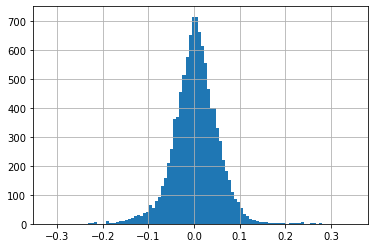

In [196]:
df.target_rtrns.hist(bins=100)

delta_0%_3%      52.312111
delta_3%_100%    47.687889
Name: target_bins, dtype: float64


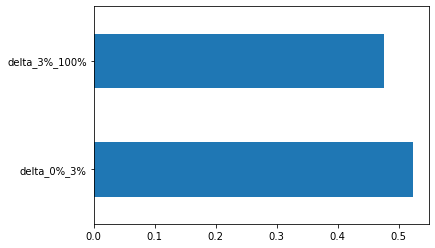

In [197]:
df.target_bins.value_counts(normalize=True).plot(kind='barh')
print(df.target_bins.value_counts(normalize=True)*100)

In [198]:
df.target_sign_binary.value_counts(normalize=True)

1    0.536168
0    0.463832
Name: target_sign_binary, dtype: float64

In [199]:
df.target_bins_sign.value_counts(normalize=True)

steady    0.523121
1         0.267113
0         0.209765
Name: target_bins_sign, dtype: float64

### Clean dataset from NAs

In [200]:
# import missingno as msno
# msno.matrix(df.set_index('opentime')[df.columns[(df.isnull().sum()!=0)]],freq='H')
from sklearn.preprocessing import LabelEncoder

In [201]:
print(f'current rows {df.shape[0]}')
print(f'max missing rows {df.isnull().sum().max()}')
print(f'opentime from {df.opentime.min().strftime("%Y-%m-%d %H:%M")} to {df.opentime.max().strftime("%Y-%m-%d %H:%M")}')

current rows 10465
max missing rows 168
opentime from 2021-01-01 00:00 to 2022-03-13 00:00


In [202]:
md = df.dropna().reset_index(drop=True).copy()
md.shape

(10277, 203)

In [203]:
print(f'remaining missing observations {md.isnull().sum().sum()}')
print(f'current rows {md.shape[0]}')
print(f'opentime from {md.opentime.min().strftime("%Y-%m-%d %H:%M")} to {md.opentime.max().strftime("%Y-%m-%d %H:%M")}')

remaining missing observations 0
current rows 10277
opentime from 2021-01-08 00:00 to 2022-03-12 04:00


In [204]:
md.target_bins_sign.value_counts()

steady    5414
1         2682
0         2181
Name: target_bins_sign, dtype: int64

In [205]:
X = md[[x for x in md.columns if not (x.startswith('target') | x.endswith('time'))]].reset_index(drop=True)
X = X.drop(['open','high','low','close','volume','numtrade'],axis=1)

In [206]:
[x for x in md.columns if x.startswith('target')]

['target_rtrns',
 'target_sign',
 'target_sign_binary',
 'target_bins',
 'target_bins_sign']

In [207]:
y = md['target_sign_binary']

In [208]:
# pd.Series(md.columns).to_clipboard()
# pd.Series(X.columns).to_clipboard()

### Temporal Train Test Split - dataset to test at the end

In [232]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [233]:
y, y_keep, X, X_keep = temporal_train_test_split(y,X,test_size=24*7*4)

In [234]:
[x.shape for x in [y, y_keep, X, X_keep]]

[(8933,), (672,), (8933, 190), (672, 190)]

In [235]:
y_keep.value_counts()

0    354
1    318
Name: target_sign_binary, dtype: int64

### Setup Cross-Validation

In [236]:
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter

### sklearn TimeSeriesSplit

In [237]:
# # tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=200)
# tscv = TimeSeriesSplit(n_splits=10)
# for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
#     print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
#     X_train, X_test = X.loc[train_index], X.loc[test_index]
#     y_train, y_test = y[train_index], y.loc[test_index]

In [238]:
def TimeSeriesCV(X,y,n_splits=20, gap=0, max_train_size=None, test_size=None, verbose=False):
    tscv = TimeSeriesSplit(n_splits=n_splits, gap=gap, max_train_size=max_train_size, test_size=test_size)
    for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y.loc[test_index]
        
        if verbose:
            print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
            #print('\nEVENT RATIO in TRAIN')
            #print(y_train.value_counts(normalize=True)*100)
            #print('\nEVENT RATIO in TEST')
            #print(y_test.value_counts(normalize=True)*100)
            #print('-'*100)
            #print()
            
        yield (X_train,y_train,X_test,y_test)

In [239]:
tscv = TimeSeriesCV(X,y,n_splits=10,verbose=True)
for xx in tscv:
    X_train,y_train,X_test,y_test = xx

(01) train : 0-812 [813] & test 813-1624 [812]
(02) train : 0-1624 [1625] & test 1625-2436 [812]
(03) train : 0-2436 [2437] & test 2437-3248 [812]
(04) train : 0-3248 [3249] & test 3249-4060 [812]
(05) train : 0-4060 [4061] & test 4061-4872 [812]
(06) train : 0-4872 [4873] & test 4873-5684 [812]
(07) train : 0-5684 [5685] & test 5685-6496 [812]
(08) train : 0-6496 [6497] & test 6497-7308 [812]
(09) train : 0-7308 [7309] & test 7309-8120 [812]
(10) train : 0-8120 [8121] & test 8121-8932 [812]


In [240]:
tscv = TimeSeriesCV(X,y,n_splits=10,verbose=True)

In [241]:
# the tscv object yields n_splits dataset everytime 'next' is used
# this will yield as many (n_splits) datasets there are and then it will prompt an error
X_train,y_train,X_test,y_test = next(tscv)
[len(x) for x in [X_train,y_train,X_test,y_test]]
X_train.tail()

(01) train : 0-812 [813] & test 813-1624 [812]


,fx_open,fx_high,fx_low,fx_close,fx_volume,fx_close_lag_001,fx_close_lag_002,...,fx_pp,fx_r1,fx_s1,fx_r2,fx_s2,fx_r3,fx_s3
808,1724.520020,1731.310059,1680.000000,1715.469971,304722.968750,1715.469971,1724.520020,...,1708.926758,1737.853516,1686.543457,1760.236816,1657.616699,1789.163574,1635.233398
809,1715.489990,1739.199951,1692.130005,1729.109985,212477.921875,1729.109985,1715.469971,...,1720.146606,1748.163208,1701.093262,1767.216675,1673.076660,1795.233154,1654.023315
810,1729.109985,1751.640015,1716.359985,1738.579956,109718.671875,1738.579956,1729.109985,...,1735.526733,1754.693481,1719.413452,1770.806763,1700.246704,1789.973511,1684.133423
811,1738.520020,1748.000000,1729.069946,1743.739990,71583.257812,1743.739990,1738.579956,...,1740.269897,1751.469849,1732.539795,1759.200073,1721.339844,1770.399902,1713.609741
812,1743.739990,1749.500000,1721.209961,1744.459961,98746.953125,1744.459961,1743.739990,...,1738.390015,1755.570068,1727.280029,1766.680176,1710.099976,1783.860107,1698.989990


### sktime SlidingWindowSplitter

In [246]:
tscv = SlidingWindowSplitter(window_length=3500, fh=list(range(1,(200+1))), step_length=1000)
n_splits = tscv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
    print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y.loc[test_index]

Number of Folds = 6
(01) train : 0-3499 [3500] & test 3500-3699 [200]
(02) train : 1000-4499 [3500] & test 4500-4699 [200]
(03) train : 2000-5499 [3500] & test 5500-5699 [200]
(04) train : 3000-6499 [3500] & test 6500-6699 [200]
(05) train : 4000-7499 [3500] & test 7500-7699 [200]
(06) train : 5000-8499 [3500] & test 8500-8699 [200]


In [247]:
def SlidingCV(X,y,window_length=1000, fh=list(range(1,(200+1))), step_length=1000, verbose=False):
    tscv = SlidingWindowSplitter(window_length=window_length, fh=fh, step_length=step_length)
    for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y.loc[test_index]
        
        if verbose:
            print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
            #print('\nEVENT RATIO in TRAIN')
            #print(y_train.value_counts(normalize=True)*100)
            #print('\nEVENT RATIO in TEST')
            #print(y_test.value_counts(normalize=True)*100)
            #print('-'*100)
            #print()
            
        yield (X_train,y_train,X_test,y_test)

In [288]:
tscv = SlidingCV(X,y,window_length=3500, fh=list(range(1,(200+1))), step_length=500, verbose=True)
for xx in tscv:
    X_train,y_train,X_test,y_test = xx

(01) train : 0-3499 [3500] & test 3500-3699 [200]
(02) train : 500-3999 [3500] & test 4000-4199 [200]
(03) train : 1000-4499 [3500] & test 4500-4699 [200]
(04) train : 1500-4999 [3500] & test 5000-5199 [200]
(05) train : 2000-5499 [3500] & test 5500-5699 [200]
(06) train : 2500-5999 [3500] & test 6000-6199 [200]
(07) train : 3000-6499 [3500] & test 6500-6699 [200]
(08) train : 3500-6999 [3500] & test 7000-7199 [200]
(09) train : 4000-7499 [3500] & test 7500-7699 [200]
(10) train : 4500-7999 [3500] & test 8000-8199 [200]
(11) train : 5000-8499 [3500] & test 8500-8699 [200]


### sktime ExpandingWindowSplitter

In [249]:
tscv = ExpandingWindowSplitter(fh=list(range(1,(200+1))), step_length=1000)
n_splits = tscv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
    print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y.loc[test_index]

Number of Folds = 9
(01) train : 0-9 [10] & test 10-209 [200]
(02) train : 0-1009 [1010] & test 1010-1209 [200]
(03) train : 0-2009 [2010] & test 2010-2209 [200]
(04) train : 0-3009 [3010] & test 3010-3209 [200]
(05) train : 0-4009 [4010] & test 4010-4209 [200]
(06) train : 0-5009 [5010] & test 5010-5209 [200]
(07) train : 0-6009 [6010] & test 6010-6209 [200]
(08) train : 0-7009 [7010] & test 7010-7209 [200]
(09) train : 0-8009 [8010] & test 8010-8209 [200]


In [250]:
def ExpandingCV(X,y,fh=list(range(1,(200+1))), step_length=1000, verbose=False):
    tscv = ExpandingWindowSplitter(fh=fh, step_length=step_length)
    for i, (train_index, test_index) in enumerate(tscv.split(X),start=1):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y.loc[test_index]
        
        if verbose:
            print(f'''({str(i).zfill(2)}) train : {train_index[0]}-{train_index[-1]} [{len(train_index)}] & test {test_index[0]}-{test_index[-1]} [{len(test_index)}]''')
            #print('\nEVENT RATIO in TRAIN')
            #print(y_train.value_counts(normalize=True)*100)
            #print('\nEVENT RATIO in TEST')
            #print(y_test.value_counts(normalize=True)*100)
            #print('-'*100)
            #print()
            
        yield (X_train,y_train,X_test,y_test)

In [251]:
tscv = ExpandingCV(X,y,verbose=True)
for xx in tscv:
    X_train,y_train,X_test,y_test = xx

(01) train : 0-9 [10] & test 10-209 [200]
(02) train : 0-1009 [1010] & test 1010-1209 [200]
(03) train : 0-2009 [2010] & test 2010-2209 [200]
(04) train : 0-3009 [3010] & test 3010-3209 [200]
(05) train : 0-4009 [4010] & test 4010-4209 [200]
(06) train : 0-5009 [5010] & test 5010-5209 [200]
(07) train : 0-6009 [6010] & test 6010-6209 [200]
(08) train : 0-7009 [7010] & test 7010-7209 [200]
(09) train : 0-8009 [8010] & test 8010-8209 [200]


### Model Training - Single dataset - Resembles Single-Split

In [252]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

In [274]:
# clf = RandomForestClassifier(class_weight='balanced')
clf = LGBMClassifier(
        class_weight='balanced',
        boosting_type='dart',
        #colsample_bytree=np.sqrt(X.shape[1])/(X.shape[1]),
        n_estimators=1000,
        objective='binary'
        )

In [275]:
[x.shape for x in (X_train,y_train)]

[(8010, 190), (8010,)]

In [276]:
clf.fit(X_train,y_train)

LGBMClassifier(boosting_type='dart', class_weight='balanced', n_estimators=1000,
               objective='binary')

In [277]:
y_preds = clf.predict(X_keep)
y_proba = clf.predict_proba(X_keep)

In [278]:
roc_auc_score(y_keep,y_preds)

0.482811000959386

In [279]:
accuracy_score(y_keep,y_preds)

0.45982142857142855

<AxesSubplot:ylabel='features'>

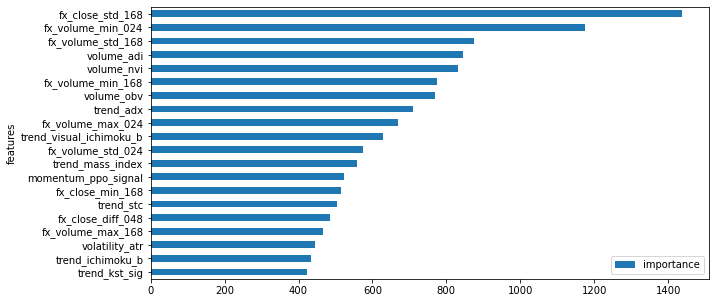

In [280]:
pd.DataFrame({'features':X_train.columns,'importance':clf.feature_importances_})\
    .set_index('features').sort_values(by=['importance'])\
    .tail(20).plot(kind='barh',figsize = (10,5))

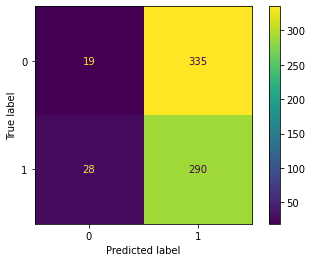

In [281]:
cm = confusion_matrix(y_keep,y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

In [282]:
pd.crosstab(y_keep,y_preds,margins=True)

col_0,0,1,All
target_sign_binary,,,
0,19,335,354
1,28,290,318
All,47,625,672


In [283]:
print(classification_report(y_keep,y_preds))

              precision    recall  f1-score   support

           0       0.40      0.05      0.09       354
           1       0.46      0.91      0.62       318

    accuracy                           0.46       672
   macro avg       0.43      0.48      0.35       672
weighted avg       0.43      0.46      0.34       672



### Model Training - Across all Folds

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 12.9 µs
(01) train : 0-3499 [3500] & test 3500-3699 [200]
Accuracy : 50.30%
ROC : 52.73%


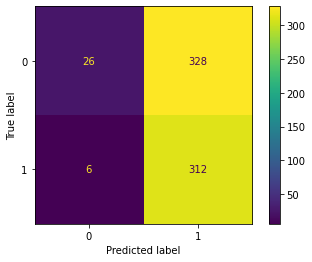

(02) train : 500-3999 [3500] & test 4000-4199 [200]
Accuracy : 52.98%
ROC : 51.83%


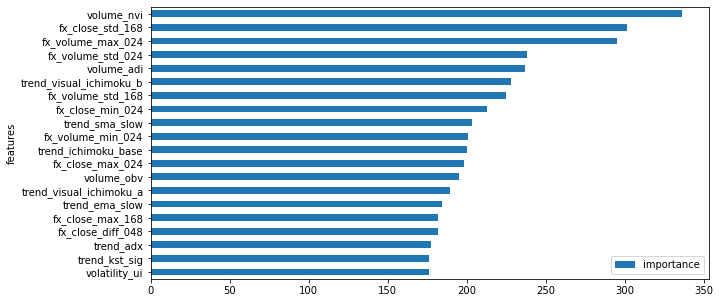

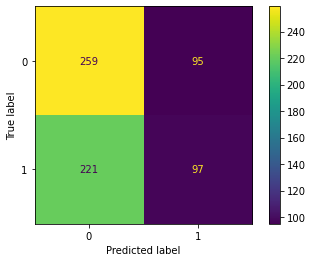

(03) train : 1000-4499 [3500] & test 4500-4699 [200]
Accuracy : 53.42%
ROC : 52.50%


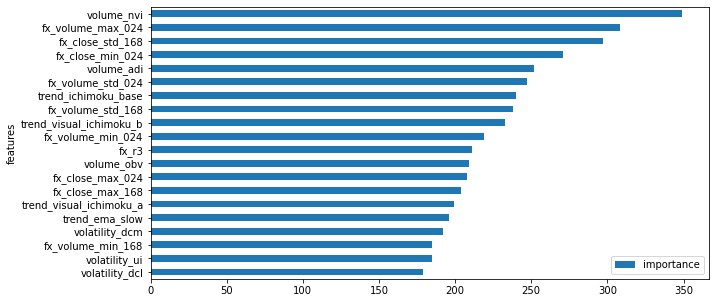

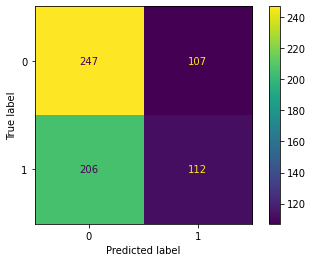

(04) train : 1500-4999 [3500] & test 5000-5199 [200]
Accuracy : 50.45%
ROC : 49.37%


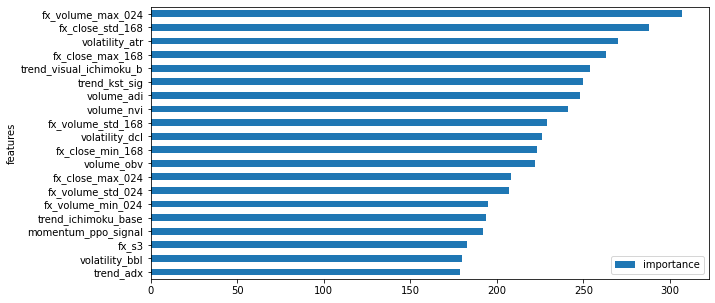

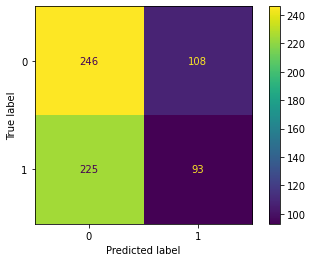

(05) train : 2000-5499 [3500] & test 5500-5699 [200]
Accuracy : 50.00%
ROC : 51.58%


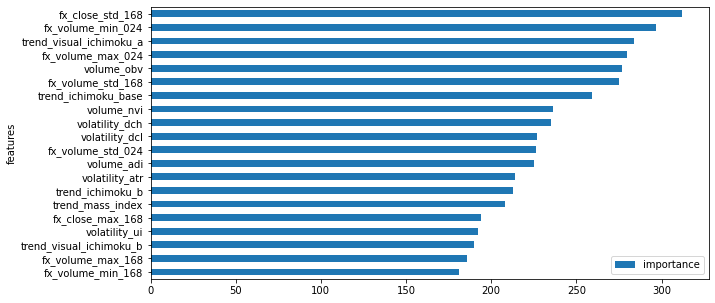

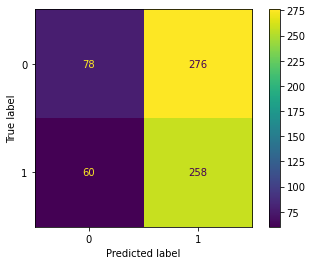

(06) train : 2500-5999 [3500] & test 6000-6199 [200]
Accuracy : 46.43%
ROC : 48.96%


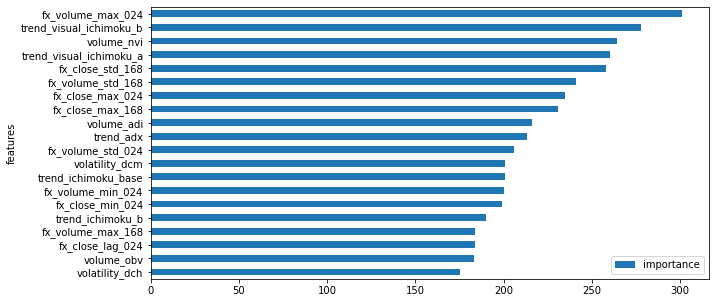

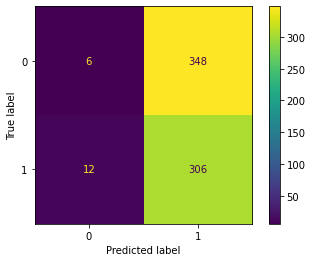

(07) train : 3000-6499 [3500] & test 6500-6699 [200]
Accuracy : 43.30%
ROC : 44.97%


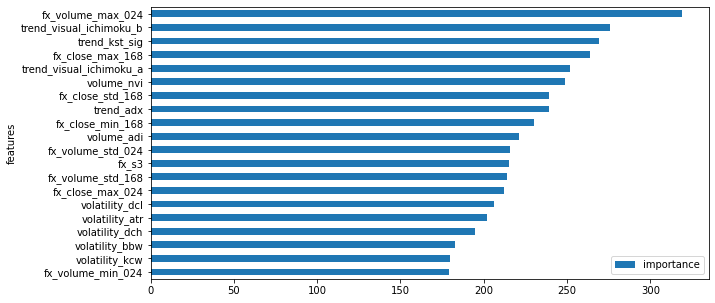

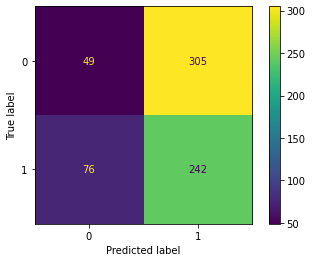

(08) train : 3500-6999 [3500] & test 7000-7199 [200]
Accuracy : 46.88%
ROC : 49.32%


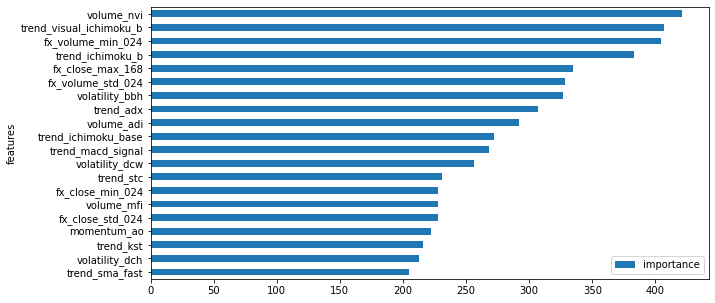

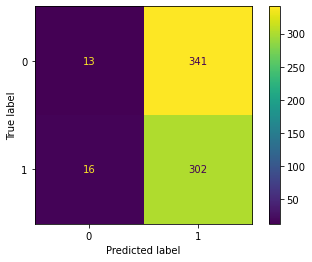

(09) train : 4000-7499 [3500] & test 7500-7699 [200]
Accuracy : 48.96%
ROC : 51.17%


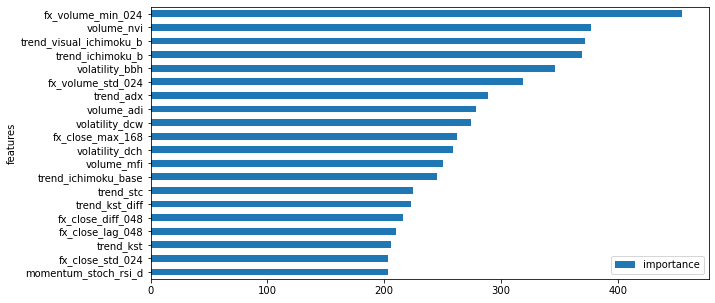

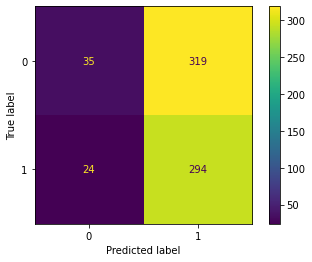

(10) train : 4500-7999 [3500] & test 8000-8199 [200]
Accuracy : 47.32%
ROC : 49.95%


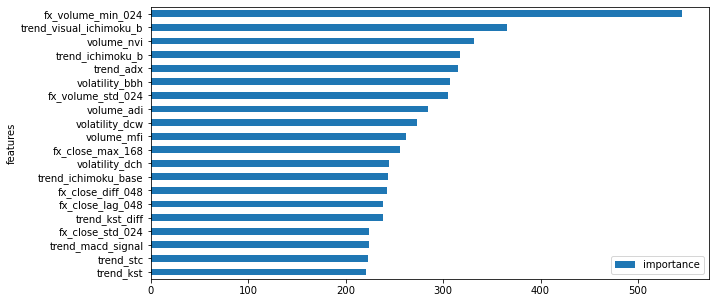

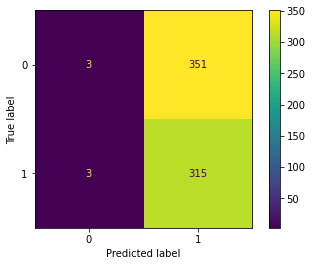

(11) train : 5000-8499 [3500] & test 8500-8699 [200]
Accuracy : 50.60%
ROC : 53.08%


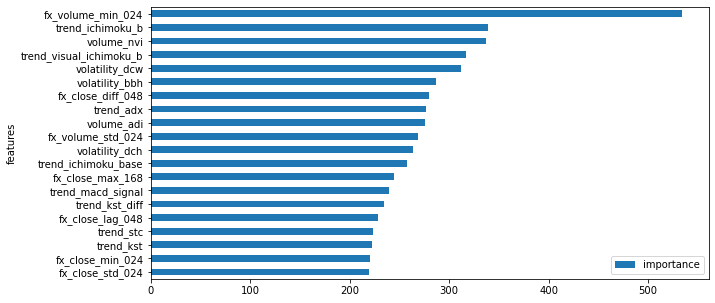

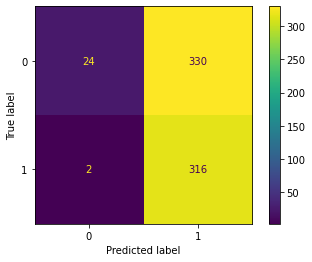

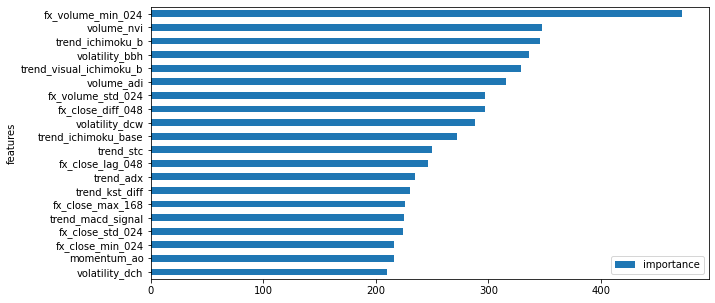

In [289]:
%time
# tscv = TimeSeriesCV(X,y,n_splits=10,test_size=24*7*4,verbose=True)
tscv = SlidingCV(X,y,window_length=3500, fh=list(range(1,(200+1))), step_length=500, verbose=True)

for foo in tscv:
    
    X_train,y_train,X_test,y_test = foo
    
    #clf = RandomForestClassifier(n_estimators=1000,class_weight='balanced',)
    clf = LGBMClassifier(
        #class_weight='balanced',
        boosting_type='dart',
        colsample_bytree=np.sqrt(X.shape[1])/(X.shape[1]),
        n_estimators=500,
        objective='binary'
        )
    
    clf.fit(X_train,y_train)
    y_preds = clf.predict(X_keep)
    
    print(f'Accuracy : {accuracy_score(y_keep,y_preds):.2%}')
    print(f'ROC : {roc_auc_score(y_keep,y_preds):.2%}')
    #print(classification_report(y_keep,y_preds))
    
    cm = confusion_matrix(y_keep,y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()
    plt.show()
    
    pd.DataFrame({'features':X_train.columns,'importance':clf.feature_importances_})\
        .set_index('features').sort_values(by=['importance'])\
        .tail(20).plot(kind='barh',figsize = (10,5))

    print(100*'=')